In [ ]:
# hidden
%pip install -r requirements.txt

### Neophodne biblioteke

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.linalg as la
import seaborn as sb
import statsmodels.api as sm
from scipy import stats

matplotlib.rcParams['figure.figsize'] = (8, 4)
sb.set(font_scale=1e0)

from linearmodels.panel import (
    PooledOLS, PanelOLS, RandomEffects, compare
)

### Konstante

In [2]:
# %load "utils\constants.py"
DATA_FILE = 'data\main-table.csv'
EXTRAPOLATED_DATA_FILE = 'data\extrapolated_data.csv'

COLS = (
    'Region', 'Year', 'TotalTourists', 'ForeignTourists', 'HousesWithInternet%',
    'CompaniesWithWebSites%', 'AmountOfPeopleWithHighEducation',
    'PeopleWithHighEducationWithoutJob', 'AmountOfPeopleWithSecondaryEducation',
    'PeopleWithSecondaryEducationWithoutJob', 'AmountOfPeopleWithoutEducation',
    'PeopleWithoutEducationWithoutJob', 'AmountOfMales',
    'AmountOfMalesWithoutJob', 'AmountOfFemales',
    'AmountOfFemalesWithoutJob', 'AmountOfPeopleInRegion',
    'AmountOfPeopleInRegionWithoutJob', 'AmountOf_15-24_PeopleInRegion',
    'AmountOf_15-24_PeopleInRegionWithoutJob', 'AmountOf_15-64_PeopleInRegion',
    'AmountOf_15-64_PeopleInRegionWithoutJob', 'AmountOf_25-34_PeopleInRegion',
    'AmountOf_25-34_PeopleInRegionWithoutJob', 'AmountOf_35-44_PeopleInRegion',
    'AmountOf_35-44_PeopleInRegionWithoutJob', 'AmountOf_45-54_PeopleInRegion',
    'AmountOf_45-54_PeopleInRegionWithoutJob', 'AmountOf_55-64_PeopleInRegion',
    'AmountOf_55-64_PeopleInRegionWithoutJob', 'AmountOf_65+_PeopleInRegion'
)

DEPENDENT_COL = 'TotalTourists'

INDEX_COLS = 'Region', 'Year'

INDEPENDENT_COLS = tuple( set(COLS) - set(INDEX_COLS) - {DEPENDENT_COL} )

REGIONS = ( 
    'РЕПУБЛИКА СРБИЈА',
    'Београдски регион', 
    'Регион Војводине', 
    'Регион Шумадије и Западне Србије', 
    'Регион Јужне и Источне Србије' 
)

### Ucitavamo i obradjujemo podatke

Posto se podaci nalaze u 6 odvojenih csv fajlova, prvo smo skriptama spojili podatke u jedan dataset koji cuvamo u posebnom fajlu. Sada mozemo da ucitamo sve podatke od jednom.

In [3]:
from typing import Tuple

def get_dataset(path, usecols=COLS, index_col=INDEX_COLS):
    """
    Loads the dataset and returns a data frame indexed by region and year for all regions, and one indexed by year for Serbia.
    """

    dataset = pd.read_csv(path, usecols=usecols, index_col=index_col)

    mask = dataset.index.get_level_values('Region') == 'РЕПУБЛИКА СРБИЈА'
    serbia = dataset[mask].droplevel('Region')

    years = dataset.index.get_level_values('Year').to_list()
    dataset['Year'] = pd.Categorical(years)

    regions = dataset[~mask].groupby('Region').apply(lambda group: group.droplevel('Region'))
    return regions, serbia

Tabelarno prikazujemo podatke za sve godine u Srbiji i iscrtavamo graf za prikaz ukupnog broja turista po regionima za sve godine.

In [4]:
regions_df, serbia_df = get_dataset(EXTRAPOLATED_DATA_FILE)

regions_df, serbia_df = regions_df.dropna(), serbia_df.dropna()

regions_grouped = regions_df.groupby("Region")

serbia_df.head(11)

,TotalTourists,ForeignTourists,HousesWithInternet%,CompaniesWithWebSites%,AmountOfPeopleWithHighEducation,PeopleWithHighEducationWithoutJob,AmountOfPeopleWithSecondaryEducation,PeopleWithSecondaryEducationWithoutJob,AmountOfPeopleWithoutEducation,PeopleWithoutEducationWithoutJob,...,AmountOf_15-64_PeopleInRegionWithoutJob,AmountOf_25-34_PeopleInRegion,AmountOf_25-34_PeopleInRegionWithoutJob,AmountOf_35-44_PeopleInRegion,AmountOf_35-44_PeopleInRegionWithoutJob,AmountOf_45-54_PeopleInRegion,AmountOf_45-54_PeopleInRegionWithoutJob,AmountOf_55-64_PeopleInRegion,AmountOf_55-64_PeopleInRegionWithoutJob,AmountOf_65+_PeopleInRegion
Year,,,,,,,,,,,,,,,,,,,,,
2010,2000597,682681,27.6,67.5,847200.0,87500.0,3226100.0,562400.0,2183100.0,183000.0,...,833400.0,1018500.0,265200.0,952900.0,179400.0,1040700.0,161700.0,1190900.0,76300.0,1150600.0
2011,2068610,764167,31.0,67.6,895300.0,93200.0,3205000.0,521100.0,2116800.0,162400.0,...,776900.0,1003500.0,248500.0,958000.0,168200.0,1024700.0,148300.0,1170800.0,71600.0,1181900.0
2012,2079643,809967,38.0,73.8,943400.0,98900.0,3183900.0,479800.0,2050500.0,141800.0,...,720400.0,988500.0,231800.0,963100.0,157000.0,1008700.0,134900.0,1150700.0,66900.0,1213200.0
2013,2192435,921768,43.4,73.8,991500.0,104600.0,3162800.0,438500.0,1984200.0,121200.0,...,663900.0,973500.0,215100.0,968200.0,145800.0,992700.0,121500.0,1130600.0,62200.0,1244500.0
2014,2192268,1028732,55.1,74.0,1039600.0,110300.0,3141700.0,397200.0,1917900.0,100600.0,...,607400.0,958500.0,198400.0,973300.0,134600.0,976700.0,108100.0,1110500.0,57500.0,1275800.0
2015,2437165,1132221,56.0,75.2,1087700.0,116000.0,3120600.0,355900.0,1851600.0,80000.0,...,550900.0,943500.0,181700.0,978400.0,123400.0,960700.0,94700.0,1090400.0,52800.0,1307100.0
2016,2753591,1281426,57.8,80.8,1114000.0,108700.0,3099200.0,309500.0,1804400.0,71200.0,...,488300.0,926200.0,161000.0,982700.0,117500.0,944400.0,84900.0,1066800.0,44900.0,1340700.0
2017,3085866,1497173,61.9,80.4,1122700.0,98900.0,3086700.0,274300.0,1775300.0,62000.0,...,1537700.0,913000.0,140100.0,985500.0,102800.0,930600.0,75900.0,1049300.0,41800.0,1366200.0
2018,3430522,1710514,72.5,82.6,1149800.0,90200.0,3074900.0,256300.0,1730400.0,65700.0,...,411000.0,899900.0,129800.0,986000.0,99600.0,922300.0,71100.0,1029700.0,45700.0,1390100.0


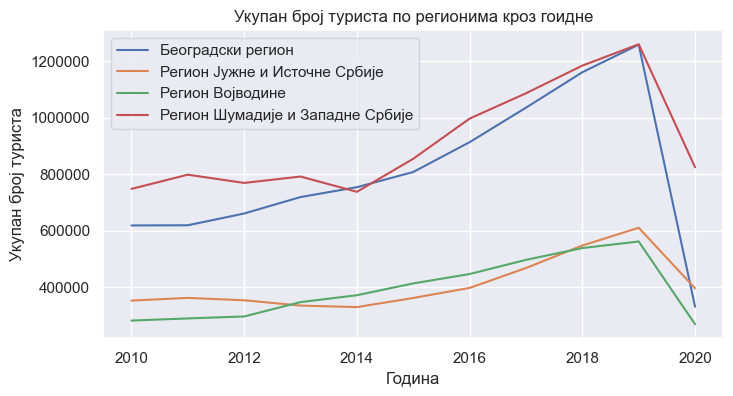

In [5]:
for region_name, region_df in regions_grouped:
    plt.plot(region_df.index.get_level_values("Year"), region_df["TotalTourists"], label=region_name)

plt.xlabel("Година")
plt.ylabel("Укупан број туриста")
plt.title("Укупан број туриста по регионима кроз гоидне")
plt.legend(loc='upper left')
plt.ticklabel_format(style='plain')
plt.show()

### Multivarijabilna regresija nad podacima za cijelu Srbiju

Fitujemo model

In [6]:
x = serbia_df.drop(columns=['TotalTourists'])
y = serbia_df['TotalTourists']

x_with_const = sm.add_constant(x)
all_vars_model = sm.OLS(y, x_with_const).fit()

Prikaz matrice korelacije

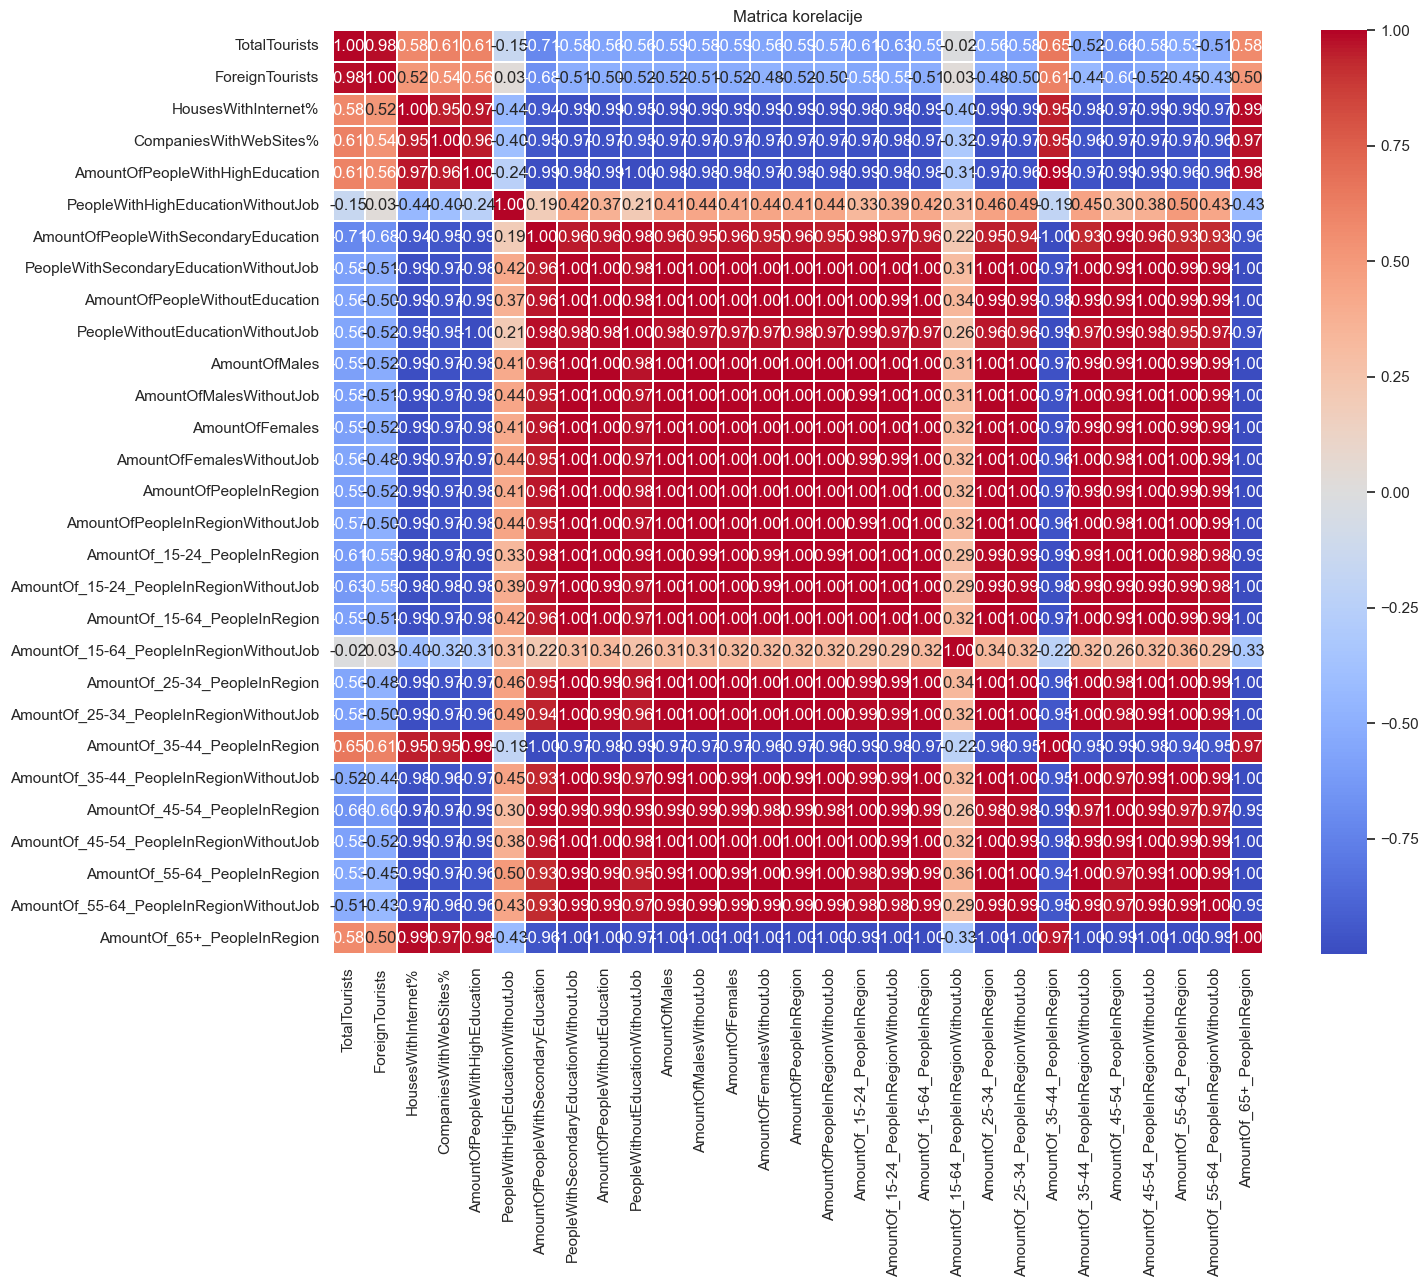

In [7]:
def plot_correlation_matrix(correlation_matrix):
    plt.figure(figsize=(15, 12))
    sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.1)
    plt.title('Matrica korelacije')
    plt.show()
    
correlation_matrix = serbia_df.corr() # racunamo matricu korelacije
plot_correlation_matrix(correlation_matrix)

Selekcija kolona koje imaju dobru korelaciju sa ukupnim brojem turista.

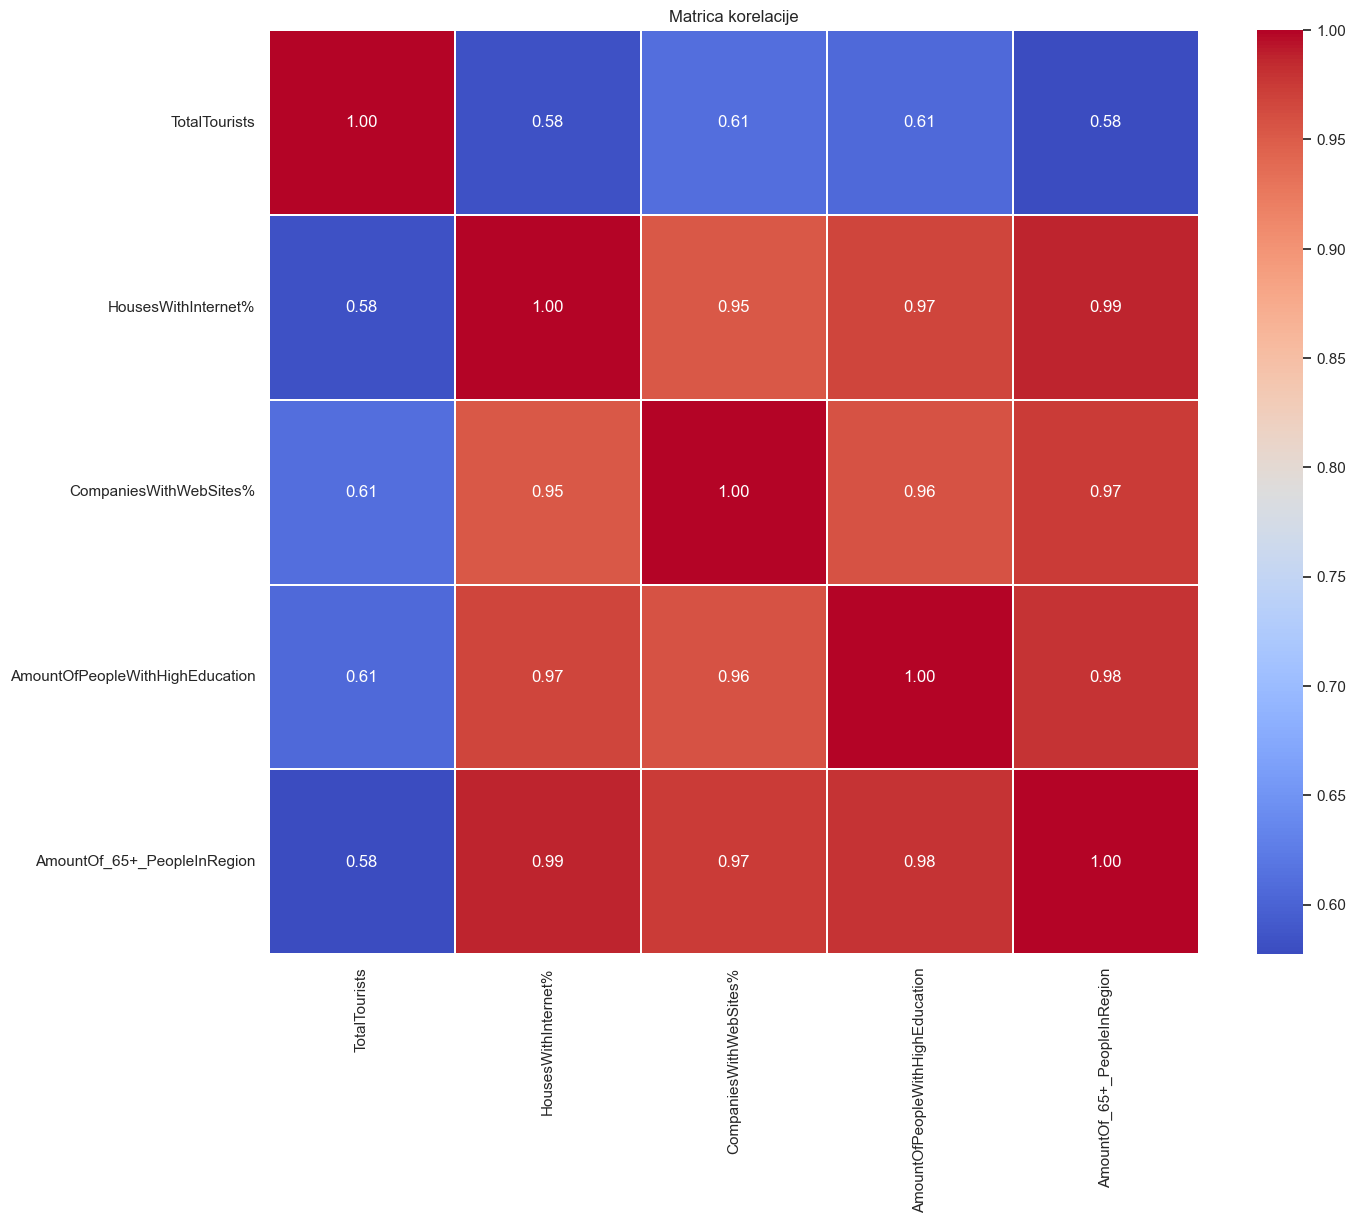

{'AmountOfPeopleWithHighEducation',
 'AmountOf_65+_PeopleInRegion',
 'CompaniesWithWebSites%',
 'ForeignTourists',
 'HousesWithInternet%'}

In [8]:
unused_columns = set()
for region in correlation_matrix.index:
    if correlation_matrix.loc[region, 'TotalTourists'] < 0.2:
        unused_columns.add(region)
unused_columns.add('AmountOf_35-44_PeopleInRegion')

serbia_df_ac = serbia_df.drop(columns=unused_columns).drop(columns=['ForeignTourists'])

x = serbia_df_ac.drop(columns=['TotalTourists'])
y = serbia_df_ac['TotalTourists']

x_with_const = sm.add_constant(x)
all_vars_model = sm.OLS(y, x_with_const).fit()

correlation_matrix = serbia_df_ac.corr() # racunamo matricu korelacije
plot_correlation_matrix(correlation_matrix)
set(INDEPENDENT_COLS) - unused_columns

### Regresija nad panelnim podacima

Multivarijabilnom regresijom, ispitivanjem matrice korelacije nad podacima za cijelu Srbiju smo zakljucili da sledece kolone imaju najjacu povezanost sa ukupnim brojem turista u regionu.

- Procenat domacinstava koje posjeduju internet konekciju: "HousesWithInternet%"
- Procenat preduzeca koja imaju web sajt: "CompaniesWithWebSites%"
- Broj visokoobrazovanih stanovnika: "AmountOfPeopleWithHighEducation"
- Broj stanovnika starijih od 65 godina: "AmountOf_65+_PeopleInRegion"

Koristeci ove kolone cemo napraviti model sa panelnim podacima i dalje ispitati njihovu povezanost sa brojem turista u regionu Srbije.

In [9]:
PANEL_COLS = ['HousesWithInternet%', 'CompaniesWithWebSites%', 'AmountOfPeopleWithHighEducation', 'AmountOf_65+_PeopleInRegion']

regions_df.loc[(REGIONS, [2018, 2019, 2020]), PANEL_COLS]

HousesWithInternet%  \
Region                           Year                        
Београдски регион                2018                 82.1   
                                 2019                 89.0   
                                 2020                 93.9   
Регион Војводине                 2018                 70.3   
                                 2019                 81.7   
                                 2020                 74.7   
Регион Шумадије и Западне Србије 2018                 71.5   
                                 2019                 75.0   
                                 2020                 77.5   
Регион Јужне и Источне Србије    2018                 66.0   
                                 2019                 71.1   
                                 2020                 77.3   

                                       CompaniesWithWebSites%  \
Region                           Year                           
Београдски регион                2018                    89.0   
                                 2019                    84.0   
                                 2020                    89.5   
Регион Војводине                 2018                    83.2   
                                 2019                    91.0   
                                 2020                    86.3   
Регион Шумадије и Западне Србије 2018                    75.5   
                                 2019                    78.9   
                                 2020                    75.5   
Регион Јужне и Источне Србије    2018                    74.5   
                                 2019                    75.4   
                                 2020                    80.5   

                                       AmountOfPeopleWithHighEducation  \
Region                           Year                                    
Београдски регион                2018                         455300.0   
                                 2019                         472500.0   
                                 2020                         470700.0   
Регион Војводине                 2018                         270000.0   
                                 2019                         264100.0   
                                 2020                         266100.0   
Регион Шумадије и Западне Србије 2018                         229400.0   
                                 2019                         235900.0   
                                 2020                         243100.0   
Регион Јужне и Источне Србије    2018                         195100.0   
                                 2019                         190100.0   
                                 2020                         194700.0   

                                       AmountOf_65+_PeopleInRegion  
Region                           Year                               
Београдски регион                2018                     321000.0  
                                 2019                     329400.0  
                                 2020                     337600.0  
Регион Војводине                 2018                     354600.0  
                                 2019                     361800.0  
                                 2020                     369500.0  
Регион Шумадије и Западне Србије 2018                     392600.0  
                                 2019                     402300.0  
                                 2020                     411600.0  
Регион Јужне и Источне Србије    2018                     321800.0  
                                 2019                     326300.0  
                                 2020                     330300.0

Pooled ordinary least squares model

In [10]:
X = regions_df[PANEL_COLS]
X_with_const = sm.add_constant(X)

y = regions_df[DEPENDENT_COL] # 'TotalTourists'
pooledOLS_res = PooledOLS(y, X_with_const).fit(cov_type='clustered', cluster_entity=True)

pooled_model_df = pd.DataFrame({
    'Actual': y,
    'Predicted': pooledOLS_res.predict().fitted_values,
    'Residuals': pooledOLS_res.resids
})

Provjeravamo nezavisnost reziduala graficki i Durbin-Watson testom.

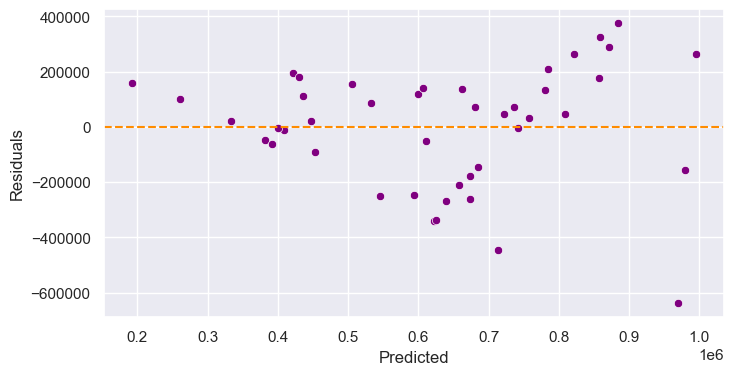

In [11]:
sb.scatterplot(x='Predicted', y='Residuals', data=pooled_model_df, color='purple')
plt.axhline(y=0, color='darkorange', linestyle='--')
plt.show()

In [12]:
from statsmodels.stats.stattools import durbin_watson

dw_value = durbin_watson(pooled_model_df['Residuals'])

f'dw_value: {dw_value:.2f} => ' \
'positive autocorrelation' if dw_value < 1.5 else \
'negative autocorrelation' if dw_value > 2 else 'no or little autocorrelation'

'dw_value: 1.25 => positive autocorrelation'

Provjeravamo da li su reziduali normalno distribuirani Anderson-Darling testom

In [13]:
from statsmodels.stats.diagnostic import normal_ad

p_value_thresh = 0.05
_, p_value = normal_ad(pooled_model_df['Residuals'])

f'p_value: {p_value:.2f} => ' \
'normal distribution of residuals' if p_value >= p_value_thresh else 'non-normal distribution of residuals'

'p_value: 0.12 => normal distribution of residuals'

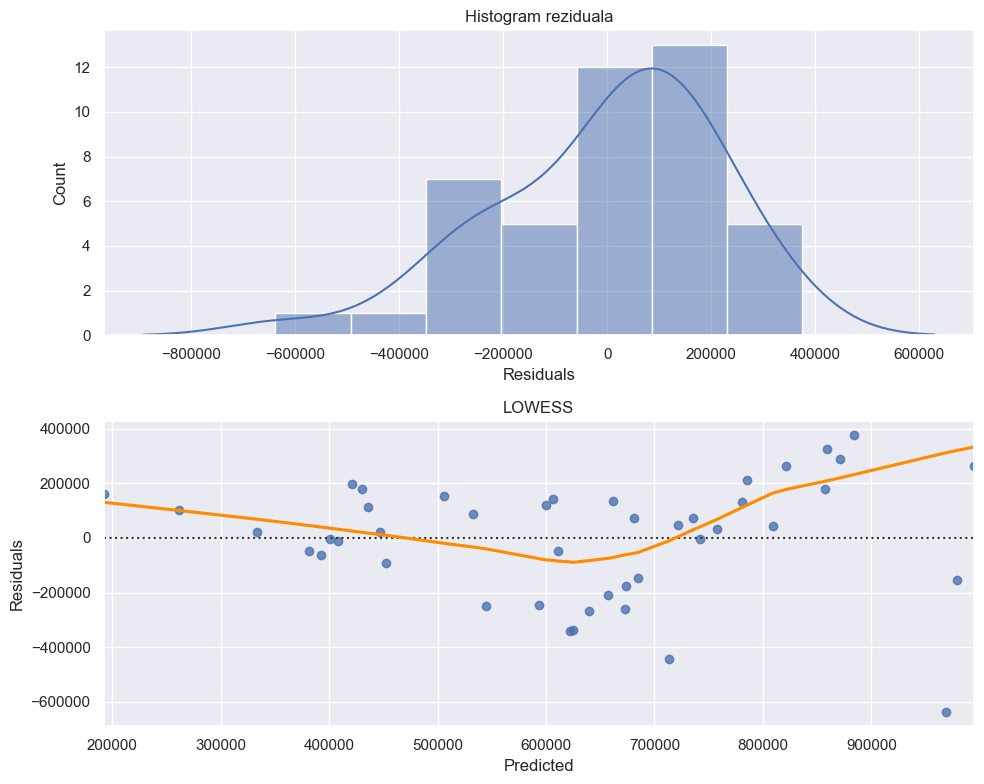

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

sb.residplot(x='Predicted', y='Residuals', data=pooled_model_df, lowess=True,  line_kws={'color': 'darkorange'}, ax=ax2)
ax2.set_title("LOWESS")

sb.histplot(pooled_model_df['Residuals'], kde=True, kde_kws={'cut':2.5}, ax=ax1)
ax1.set_title("Histogram reziduala")

plt.tight_layout()
plt.show()

Uocili smo pozitivnu autokorelaciju reziduala u OLS modelu sto nam ukazuje da bi FE ili RE model mozda bio prikladniji za nase podatke.

Fixed effects model

In [15]:
fixed_effects_res = PanelOLS(y, X_with_const, entity_effects=True).fit()
fixed_effects_res

Dep. Variable:,TotalTourists,R-squared:,0.2753
Estimator:,PanelOLS,R-squared (Between):,0.2511
No. Observations:,44,R-squared (Within):,0.2753
Date:,"Sun, Feb 04 2024",R-squared (Overall):,0.2595
Time:,22:38:54,Log-likelihood,-585.25
Cov. Estimator:,Unadjusted,,
,,F-statistic:,3.4181
Entities:,4,P-value,0.0181
Avg Obs:,11.000,Distribution:,"F(4,36)"
Min Obs:,11.000,,
Max Obs:,11.000,F-statistic (robust):,3.4181


Random effects model

In [16]:
random_effects_res = RandomEffects(y, X_with_const).fit()
random_effects_res

Dep. Variable:,TotalTourists,R-squared:,0.4478
Estimator:,RandomEffects,R-squared (Between):,0.6011
No. Observations:,44,R-squared (Within):,0.1602
Date:,"Sun, Feb 04 2024",R-squared (Overall):,0.4478
Time:,22:38:55,Log-likelihood,-602.50
Cov. Estimator:,Unadjusted,,
,,F-statistic:,7.9070
Entities:,4,P-value,0.0001
Avg Obs:,11.000,Distribution:,"F(4,39)"
Min Obs:,11.000,,
Max Obs:,11.000,F-statistic (robust):,7.9070


In [17]:
compare({'FE': fixed_effects_res, 'RE': random_effects_res})

,FE,RE
Dep. Variable,TotalTourists,TotalTourists
Estimator,PanelOLS,RandomEffects
No. Observations,44,44
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.2753,0.4478
R-Squared (Within),0.2753,0.1602
R-Squared (Between),0.2511,0.6011
R-Squared (Overall),0.2595,0.4478
F-statistic,3.4181,7.9070
P-value (F-stat),0.0181,0.0001


In [18]:
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fixed_effects_res, random_effects_res) 
'chi-Squared: {}|degrees of freedom: {}|p-Value: {}'.format(*hausman_results).split('|')

['chi-Squared: -0.4318378948587698', 'degrees of freedom: 5', 'p-Value: 1.0']